# 0. Preâmbulo 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import (SeasonalNaive, AutoARIMA, AutoETS, Naive)
from datasetsforecast.losses import (mae, mape, mse, mase, rmse, smape)
from tqdm.autonotebook import tqdm

c:\Users\Maria Inês\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# 1. Importação dos dados intermédios

In [3]:
df_grouped = pd.read_csv('Dados_intermedios/df_nb1.csv')
df_grouped = df_grouped.set_index('index')
df_grouped.columns

Index(['11.3.1.2 - Vitaminas hidrossolúveis',
       '2.10 - Analgésicos e antipiréticos', '5 - Sistema Respiratório'],
      dtype='object')

# 2. Pré-processamento das séries temporais


In [4]:
Y_df = (df_grouped
        .reset_index()
        .rename(columns={'index':'ds', 
                         '11.3.1.2 - Vitaminas hidrossolúveis':'vitaminas', 
                         '2.10 - Analgésicos e antipiréticos':'analg_antip',
                         '5 - Sistema Respiratório':'resp'}) 
        )
Y_df.columns.name = None
Y_df = pd.melt(Y_df, id_vars=['ds'])
Y_df = (Y_df
        .rename(columns={'variable':'unique_id', 
                            'value':'y'})
        .filter(['unique_id', 'ds', 'y'])
        )

Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df

,unique_id,ds,y
0,vitaminas,2013-01-01,119.27
1,vitaminas,2013-02-01,82.67
2,vitaminas,2013-03-01,24.84
3,vitaminas,2013-04-01,12.42
4,vitaminas,2013-05-01,49.02
...,...,...,...
364,resp,2022-11-01,0.00
365,resp,2022-12-01,9.83
366,resp,2023-01-01,19.66
367,resp,2023-02-01,19.66


In [5]:
print(Y_df.dtypes)

unique_id            object
ds           datetime64[ns]
y                   float64
dtype: object


In [6]:
# Substituir NaN por 0
Y_df = Y_df.fillna(0)

In [7]:
# mudar os nomes das colunas
df = Y_df[Y_df['unique_id'].isin(['vitaminas', 'analg_antip', 'resp'])]

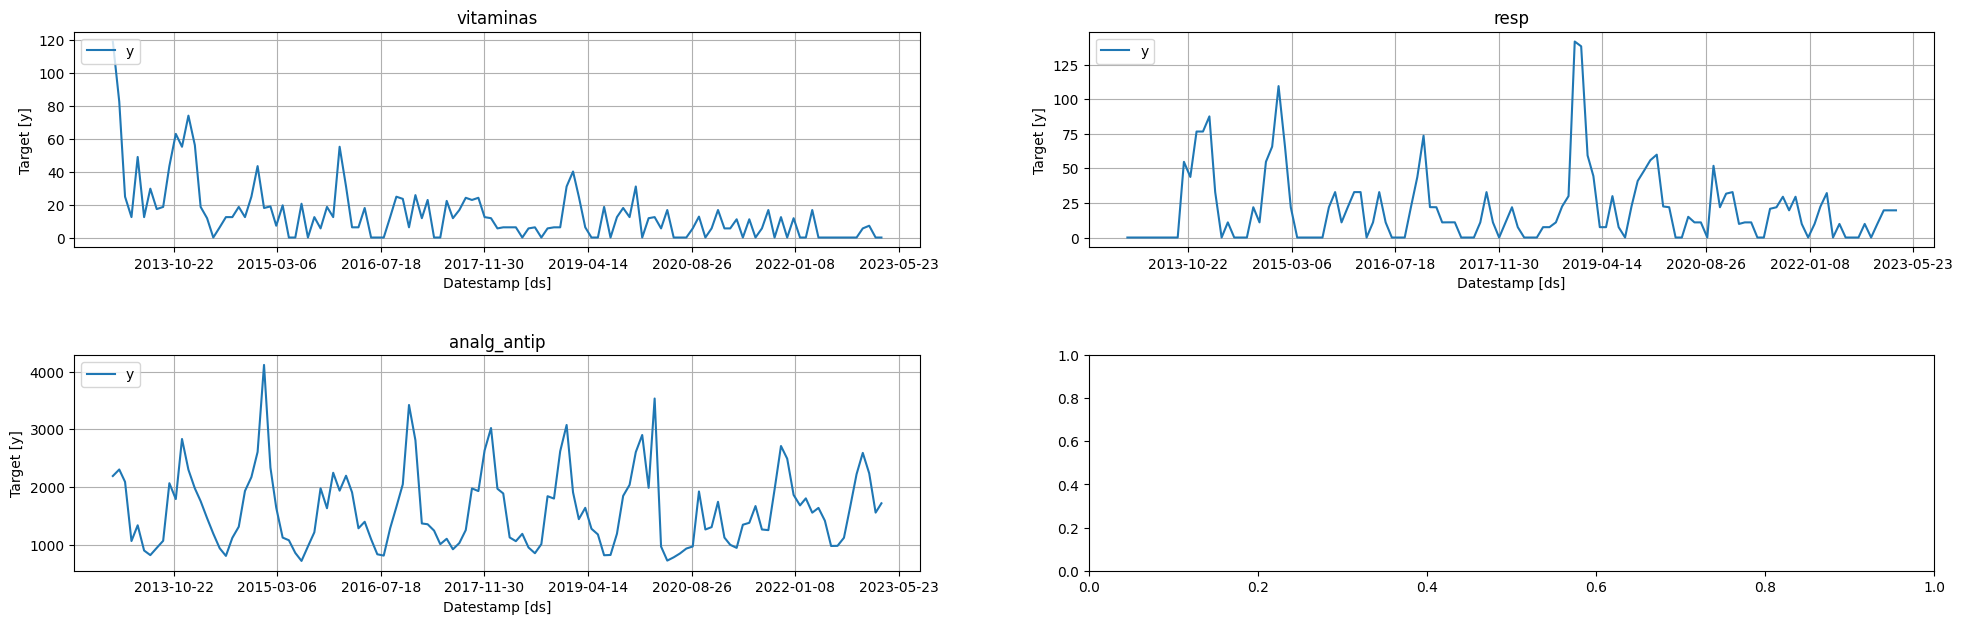

In [8]:
StatsForecast.plot(df)

# 3. Lista de modelos a testar

In [9]:
model_list = [
            Naive(),
            SeasonalNaive(season_length=12),
            AutoETS(season_length=12),
            AutoARIMA(season_length=12),
            AutoARIMA(d=0, season_length=12, alias='ARIMA_D0'), 
            AutoARIMA(d=1, season_length=12, alias='ARIMA_D1')
            ]

sf = StatsForecast(df=Y_df, 
                   models=model_list, 
                   freq='M',
                   n_jobs=-1,
                   fallback_model = SeasonalNaive(season_length=12))


# 4. Avaliação da performance

In [10]:
crossvalidation_df = sf.cross_validation(
    df = df,
    h = 1,
    step_size = 1,
    n_windows = 24
  )

crossvalidation_df

,ds,cutoff,y,Naive,SeasonalNaive,AutoETS,AutoARIMA,ARIMA_D0,ARIMA_D1
unique_id,,,,,,,,,
analg_antip,2021-03-31,2021-02-28,941.679993,994.510010,965.229980,867.423096,1277.409058,1277.409058,782.904541
analg_antip,2021-04-30,2021-03-31,1343.770020,941.679993,720.849976,792.763855,1064.415649,1064.415649,653.579102
analg_antip,2021-05-31,2021-04-30,1377.000000,1343.770020,777.630005,931.259766,1253.079102,1253.079102,1036.937866
analg_antip,2021-06-30,2021-05-31,1667.819946,1377.000000,844.049988,812.753174,925.311462,925.311462,769.339478
analg_antip,2021-07-31,2021-06-30,1261.130005,1667.819946,929.909973,903.577576,1039.355103,1039.355103,937.350891
...,...,...,...,...,...,...,...,...,...
vitaminas,2022-10-31,2022-09-30,0.000000,0.000000,12.420000,17.304583,3.862573,7.396333,3.862573
vitaminas,2022-11-30,2022-10-31,5.550000,0.000000,0.000000,12.102457,-0.304920,-0.077055,-0.304920
vitaminas,2022-12-31,2022-11-30,7.180000,5.550000,11.760000,27.828352,9.739819,13.226835,9.739819


## 4.1. Medidas de Exatidão


### 4.1.1. Analgésicos e antipiréticos

In [11]:
ts = crossvalidation_df.query('unique_id == "analg_antip"').reset_index()['y']
f1 = crossvalidation_df.query('unique_id == "analg_antip"').reset_index()['SeasonalNaive']
f2 = crossvalidation_df.query('unique_id == "analg_antip"').reset_index()['AutoETS']
f3 = crossvalidation_df.query('unique_id == "analg_antip"').reset_index()['AutoARIMA']
f4 = crossvalidation_df.query('unique_id == "analg_antip"').reset_index()['ARIMA_D0']
f5 = crossvalidation_df.query('unique_id == "analg_antip"').reset_index()['ARIMA_D1']

eval = pd.DataFrame({
    'rmse': [rmse(ts, f1), rmse(ts, f2), rmse(ts, f3), rmse(ts, f4), rmse(ts, f5)],
    'mae': [mae(ts, f1), mae(ts, f2), mae(ts, f3), mae(ts, f4), mae(ts, f5)],
    'mape': [mape(ts, f1), mape(ts, f2), mape(ts, f3), mape(ts, f4), mape(ts, f5)],
}, index=crossvalidation_df.columns[4:])
eval


,rmse,mae,mape
SeasonalNaive,564.778931,432.047089,25.999469
AutoETS,410.791107,317.398163,18.837750
AutoARIMA,404.430603,302.489380,17.583044
ARIMA_D0,404.430603,302.489380,17.583044
ARIMA_D1,454.440277,360.566040,21.009411


### 4.1.2. Sistema respiratório

In [12]:
ts = crossvalidation_df.query('unique_id == "resp"').reset_index()['y']
f1 = crossvalidation_df.query('unique_id == "resp"').reset_index()['SeasonalNaive']
f2 = crossvalidation_df.query('unique_id == "resp"').reset_index()['AutoETS']
f3 = crossvalidation_df.query('unique_id == "resp"').reset_index()['AutoARIMA']
f4 = crossvalidation_df.query('unique_id == "resp"').reset_index()['ARIMA_D0']
f5 = crossvalidation_df.query('unique_id == "resp"').reset_index()['ARIMA_D1']

eval = pd.DataFrame({
    'rmse': [rmse(ts, f1), rmse(ts, f2), rmse(ts, f3), rmse(ts, f4), rmse(ts, f5)],
    'mae': [mae(ts, f1), mae(ts, f2), mae(ts, f3), mae(ts, f4), mae(ts, f5)],
    'mape': [mape(ts, f1), mape(ts, f2), mape(ts, f3), mape(ts, f4), mape(ts, f5)],
}, index=crossvalidation_df.columns[4:])
eval


,rmse,mae,mape
SeasonalNaive,18.253548,14.865833,49.584422
AutoETS,18.655624,14.463870,77.298641
AutoARIMA,12.533345,10.823436,48.530391
ARIMA_D0,12.533345,10.823436,48.530391
ARIMA_D1,12.042483,9.856091,32.277921


### 4.1.3. Vitaminas hidrossolúveis

In [13]:
ts = crossvalidation_df.query('unique_id == "vitaminas"').reset_index()['y']
f1 = crossvalidation_df.query('unique_id == "vitaminas"').reset_index()['Naive']
f2 = crossvalidation_df.query('unique_id == "vitaminas"').reset_index()['AutoETS']
f3 = crossvalidation_df.query('unique_id == "vitaminas"').reset_index()['AutoARIMA']
f4 = crossvalidation_df.query('unique_id == "vitaminas"').reset_index()['ARIMA_D0']
f5 = crossvalidation_df.query('unique_id == "vitaminas"').reset_index()['ARIMA_D1']

eval = pd.DataFrame({
    'rmse': [rmse(ts, f1), rmse(ts, f2), rmse(ts, f3), rmse(ts, f4), rmse(ts, f5)],
    'mae': [mae(ts, f1), mae(ts, f2), mae(ts, f3), mae(ts, f4), mae(ts, f5)],
    'mape': [mape(ts, f1), mape(ts, f2), mape(ts, f3), mape(ts, f4), mape(ts, f5)],
}, index=crossvalidation_df.columns[np.array([3,5,6,7,8])])
eval

,rmse,mae,mape
Naive,9.280926,7.022083,30.814493
AutoETS,11.882367,9.931502,43.899778
AutoARIMA,8.723654,6.968501,35.121450
ARIMA_D0,8.767180,7.516944,30.158210
ARIMA_D1,8.723654,6.968501,35.121450


In [14]:
crossvalidation_df.to_csv('crossvalidationGEC.csv')

## 4.2. Ajustar o modelo

### 4.2.1. AutoARIMA

#### 4.2.1.1. Analgésicos e antipiréticos

In [15]:
model_list_AutoARIMA = [AutoARIMA(season_length=12)]

sf = StatsForecast(df=Y_df.query('unique_id == "analg_antip"'), 
                   models=model_list_AutoARIMA, 
                   freq='M',
                   n_jobs=-1)

In [16]:
df_aux = Y_df.query('unique_id == "analg_antip"').reset_index(drop=True)
forecasts_df = sf.forecast(df=df_aux, h=1, level=[95,80])

df_faux = forecasts_df.reset_index()
df_faux.ds = df_faux.ds + pd.offsets.MonthBegin()

df_aux_all = pd.concat([df_aux,df_faux])

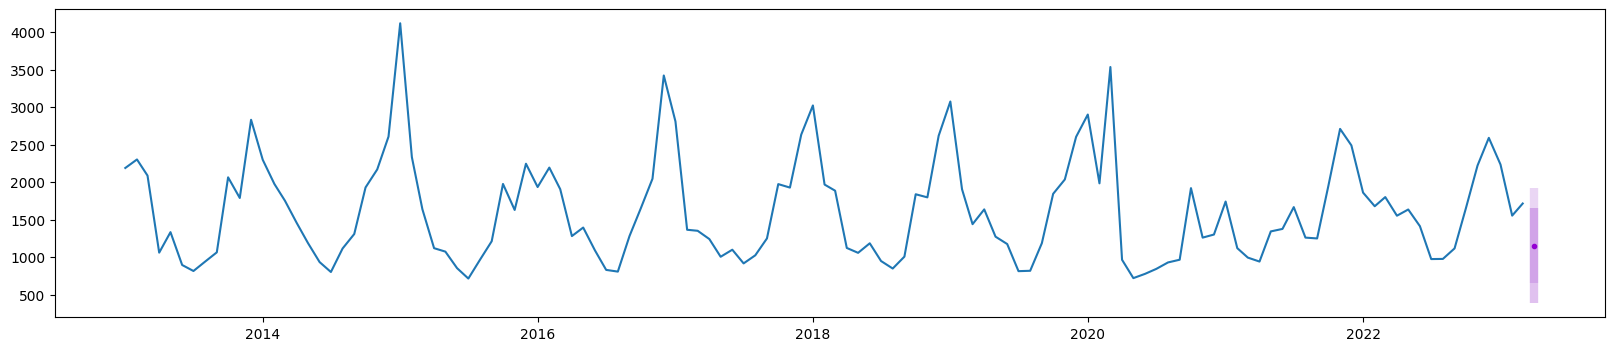

In [17]:
df_y = df_aux_all.set_index('ds').filter(['y'])
df_f = df_aux_all.set_index('ds').iloc[:,[2]]
lo_80 = df_aux_all.iloc[-1,4]
hi_80 = df_aux_all.iloc[-1,6]
lo_95 = df_aux_all.iloc[-1,5]
hi_95 = df_aux_all.iloc[-1,7]

fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(df_y)
ax.plot(df_f, marker='.', color='darkviolet')
ax.fill_between(x=df_f.index[-1:], y1=lo_80, y2=hi_80, color='darkorchid', alpha=0.3, linewidth=6)
ax.fill_between(x=df_f.index[-1:], y1=lo_95, y2=hi_95, color='darkorchid', alpha=0.2, linewidth=6)
plt.show()

#### 4.2.1.2. Vitaminas hidrossolúveis

In [18]:
model_list_AutoARIMA = [AutoARIMA(season_length=12)]

sf = StatsForecast(df=Y_df.query('unique_id == "vitaminas"'), 
                   models=model_list_AutoARIMA, 
                   freq='M',
                   n_jobs=-1)

In [19]:
df_aux = Y_df.query('unique_id == "vitaminas"').reset_index(drop=True)
forecasts_df = sf.forecast(df=df_aux, h=1, level=[95,80])

df_faux = forecasts_df.reset_index()
df_faux.ds = df_faux.ds + pd.offsets.MonthBegin()

df_aux_all = pd.concat([df_aux,df_faux])

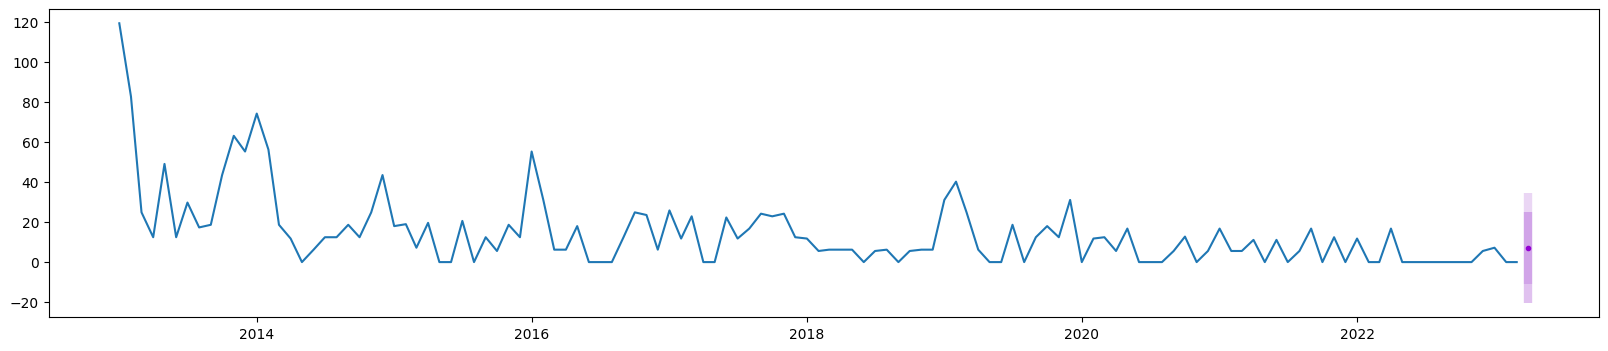

In [20]:
df_y = df_aux_all.set_index('ds').filter(['y'])
df_f = df_aux_all.set_index('ds').iloc[:,[2]]
lo_80 = df_aux_all.iloc[-1,4]
hi_80 = df_aux_all.iloc[-1,6]
lo_95 = df_aux_all.iloc[-1,5]
hi_95 = df_aux_all.iloc[-1,7]

fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(df_y)
ax.plot(df_f, marker='.', color='darkviolet')
ax.fill_between(x=df_f.index[-1:], y1=lo_80, y2=hi_80, color='darkorchid', alpha=0.3, linewidth=6)
ax.fill_between(x=df_f.index[-1:], y1=lo_95, y2=hi_95, color='darkorchid', alpha=0.2, linewidth=6)
plt.show()

### 4.2.2. AutoETS

#### 4.2.2.1. Sistema Respiratório

In [21]:
model_list_AutoETS = [AutoETS(season_length=12)]

sf = StatsForecast(df=Y_df.query('unique_id == "resp"'), 
                   models=model_list_AutoETS, 
                   freq='M',
                   n_jobs=-1)

In [22]:
df_aux = Y_df.query('unique_id == "resp"').reset_index(drop=True)
forecasts_df = sf.forecast(df=df_aux, h=1, level=[95,80])

df_faux = forecasts_df.reset_index()
df_faux.ds = df_faux.ds + pd.offsets.MonthBegin()

df_aux_all = pd.concat([df_aux,df_faux])

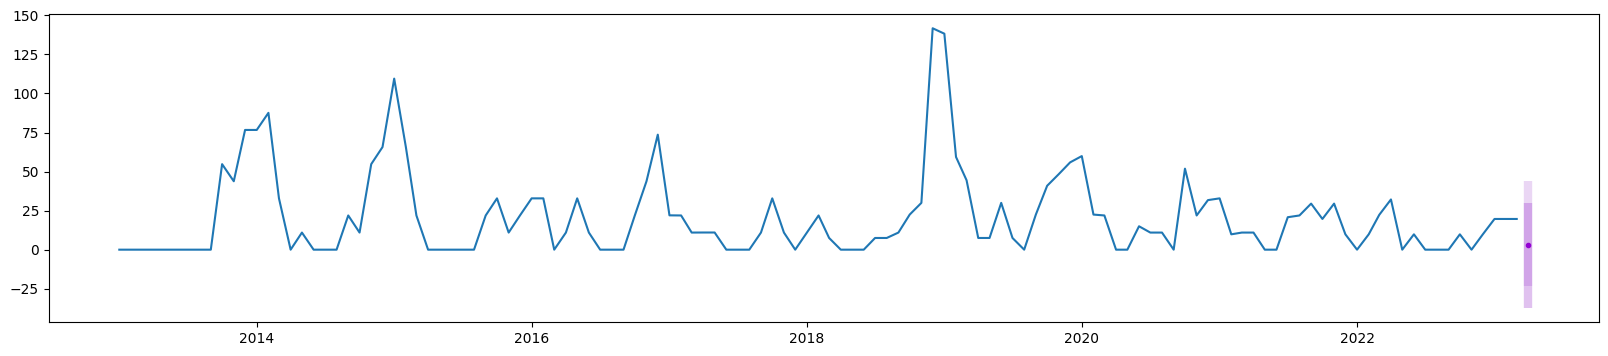

In [23]:
df_y = df_aux_all.set_index('ds').filter(['y'])
df_f = df_aux_all.set_index('ds').iloc[:,[2]]
lo_80 = df_aux_all.iloc[-1,4]
hi_80 = df_aux_all.iloc[-1,6]
lo_95 = df_aux_all.iloc[-1,5]
hi_95 = df_aux_all.iloc[-1,7]

fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(df_y)
ax.plot(df_f, marker='.', color='darkviolet')
ax.fill_between(x=df_f.index[-1:], y1=lo_80, y2=hi_80, color='darkorchid', alpha=0.3, linewidth=6)
ax.fill_between(x=df_f.index[-1:], y1=lo_95, y2=hi_95, color='darkorchid', alpha=0.2, linewidth=6)
plt.show()